In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance, plot_tree, to_graphviz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('data.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_109,Feature_110,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118
0,1,2,2,56,12,1,7.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,1,1,0
1,2,2,2,69,19,1,6.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,1
2,3,2,1,66,8,1,4.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0
3,4,2,2,62,16,1,NaN,3.0,0,1.0,...,1.0,0.0,1,0,1,1,0,0,1,1
4,5,2,2,67,30,1,NaN,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0


In [3]:
df = df_init.copy()

target_feature = 'Result'
num_features = ['Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46',
                'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_53', 'Feature_55', 'Feature_57', 
                'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 'Feature_71', 'Feature_72', 'Feature_73']
for col in df.columns:
    if col in num_features:
        df[col].fillna(df[col].median(), inplace=True)
        df[col].astype('float64')
    else:
        df[col].fillna(-1, inplace=True)
        df[col].astype('int64')

trash_features = []
drop_susp_features = False

golden_features = ['Feature_3', 'Feature_4', 'Feature_35']
susp_features = ['Feature_29', 'Feature_30', 'Feature_32', 'Feature_101'] if drop_susp_features else []
all_features = df.columns.drop([target_feature] + golden_features + susp_features + trash_features + ['Id']).tolist()

df = df[[target_feature] + all_features]

# Result=0 - alive, Result=1 died
df.loc[df[target_feature] == 1, target_feature] = 1
df.loc[df[target_feature] == 2, target_feature] = 0

In [4]:
X = df[all_features]
y = df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.1,
    random_state=0,
    stratify=y
)

over_sampler = RandomOverSampler(
    random_state=0
)
X_bal_over, y_bal_over = over_sampler.fit_resample(
    X_train,
    y_train,
)

params_frozen = {
    "objective": "reg:logistic",
    "eval_metric": "error",
    "missing": -1,
    "verbosity": 1,
}

params_grid = {
    "n_estimators": [50, 100, 200],
    "lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.2],
    "learning_rate": [0.1, 0.3, 0.5],
    "max_depth": [4, 6, 8],
}

clf=XGBClassifier(**params_frozen)
gs = GridSearchCV(
    clf,
    params_grid,
    cv=5,
)
gs.fit(X_bal_over, y_bal_over)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='error',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=-1, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:logistic',
                                     random_state=None, reg_alpha=None,
                           

In [5]:
clf_final=XGBClassifier(**params_frozen, **gs.best_params_)
clf_final.fit(
    X_bal_over,
    y_bal_over,
    eval_set=[(X_bal_over, y_bal_over), (X_test, y_test)],
    verbose=False,
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1, learning_rate=0.1,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=-1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [6]:
y_test_pred = clf_final.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Accuracy: 0.93
F1 Score: 0.91

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.83      1.00      0.91         5

    accuracy                           0.93        15
   macro avg       0.92      0.95      0.93        15
weighted avg       0.94      0.93      0.93        15



In [7]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf_final.feature_importances_),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
97,Feature_101,0.314538
2,Feature_5,0.064576
54,Feature_58,0.063746
52,Feature_56,0.045198
53,Feature_57,0.038008
29,Feature_32,0.036266
41,Feature_45,0.030227
43,Feature_47,0.030119
31,Feature_34,0.029175
66,Feature_70,0.025371


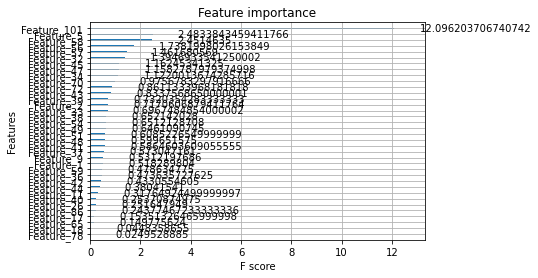

In [8]:
plot_importance(
    booster=clf_final,
    importance_type='gain'
)